# Combinatorial library vs. ChEMBL

## Aims of this notebook

In this notebook we want to compare the combinatorial library to the ChEMBL 25 dataset:

1. How similar are recombined ligands to ChEMBL ligands?
2. Which recombined ligands have exact matches in ChEMBL?

Note that the combinatorial library is stored as `json` file (~6M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here.

## Table of contents

1. Most similar ChEMBL ligands
2. Exact matches  
  2.1. Get exact matches  
  2.2. Get ChEMBL clients and set up filtering documentation  
  2.3. Get molecules from ChEMBL (by InChI key)  
  2.4. Get molecules with human targets in ChEMBL  
  2.5. Check molecule/target/assay/bioactivity distributions  
  2.6. Get active molecules (among the exact matches)  
  2.7. Get target metadata (PTC) for active molecules  
  2.8. Results  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from chembl_webresource_client.new_client import new_client
import ijson
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

from utils import get_protein_target_classifications

In [3]:
ACTIVITY_THRESHOLD = 500

## 1. Most similar ChEMBL ligands

## 2. Exact matches

### 2.1. Get exact matches

In [4]:
exact_matches = pd.read_json('../data/combinatorial_library/chembl_exact.json')

In [5]:
print(exact_matches.shape[0])
exact_matches.head()

299


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,original_exact,original_substructure,inchi
0,"[[B1_7, GA_10], [AP_12, SE_13], [AP_11, GA_9]]","[GA_35, B1_19, AP_6, SE_1]",1,1,0,0,40,1,0,0,InChI=1S/C32H28ClFN4O2/c33-29-18-27(9-11-31(29...
1,"[[AP_9, FP_6], [AP_8, SE_8]]","[AP_99, SE_16, FP_25]",1,1,1,1,22,1,0,0,InChI=1S/C16H13N3O2S/c1-21-13-6-4-12(5-7-13)18...
2,"[[AP_9, FP_6], [AP_8, SE_6]]","[AP_99, FP_103, SE_138]",1,1,1,1,20,1,0,0,InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13...
3,"[[AP_9, FP_6], [SE_7, AP_8]]","[SE_38, FP_103, AP_99]",1,1,1,1,21,1,0,0,InChI=1S/C16H11ClN2OS/c17-12-6-8-13(9-7-12)18-...
4,"[[B1_7, GA_10], [SE_14, AP_12], [AP_11, GA_9]]","[GA_35, B1_19, AP_6, SE_2]",1,1,0,0,41,1,0,0,InChI=1S/C32H26ClFN4O3/c33-28-18-26(9-11-30(28...


### 2.2. Get ChEMBL clients and set up filtering documentation

In [6]:
similarity_client = new_client.similarity
molecule_client = new_client.molecule
activity_client = new_client.activity
target_client = new_client.target

In [7]:
def add_filtering_step(filtering, df, step_name):
    
    return filtering.append(
        pd.Series(
            [
                step_name,
                len(df.molecule_chembl_id.unique()),
                len(df.target_chembl_id.unique()),
                len(df.assay_chembl_id.unique()),
                df.shape[0]
            ],
            index=['filtering_step', 'molecules', 'targets', 'assays', 'activities']
        ),
        ignore_index=True
    )

In [8]:
# Initialize filtering table
filtering = pd.DataFrame(columns=['filtering_step', 'molecules', 'targets', 'assays', 'activities'])

### 2.3. Get molecules from ChEMBL (by InChI key)

- Get molecule data from ChEMBL
- Approved molecules?
- ATC classified molecules?

#### Get molecule data from ChEMBL

In [9]:
# Get InChI keys (will be queries for ChEMBL)
exact_matches['inchi_key'] = exact_matches.inchi.apply(lambda x: Chem.InchiToInchiKey(x))

In [10]:
def get_molecules(inchi_keys):
    
    result = [molecule_client.get(inchi_key) for inchi_key in inchi_keys]
    
    molecules = pd.DataFrame(result)
    molecules = molecules[['molecule_chembl_id', 'molecule_structures', 'first_approval', 'atc_classifications', 'indication_class', 'pref_name']]
    molecules['smiles'] = molecules.molecule_structures.apply(lambda x: x['canonical_smiles'])
    molecules['inchi'] = molecules.molecule_structures.apply(lambda x: x['standard_inchi'])
    molecules.drop('molecule_structures', axis=1, inplace=True)
    PandasTools.AddMoleculeColumnToFrame(molecules, 'smiles')
    
    print(f'Number of queries: {len(inchi_keys)}')
    print(f'Number of query results: {molecules.shape[0]}')
    
    return molecules

In [11]:
molecules = get_molecules(exact_matches.inchi_key)

Number of queries: 299
Number of query results: 299


#### Approved molecules?

,molecule_chembl_id,first_approval,atc_classifications,indication_class,pref_name,smiles,inchi,ROMol
83,CHEMBL490,1992.0,[N06AB05],Antidepressant,PAROXETINE,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,InChI=1S/C19H20FNO3/c20-15-3-1-13(2-4-15)17-7-...,
260,CHEMBL64,1952.0,"[J04AC51, J04AC01]",Antibacterial (tuberculostatic),ISONIAZID,NNC(=O)c1ccncc1,InChI=1S/C6H7N3O/c7-9-6(10)5-1-3-8-4-2-5/h1-4H...,

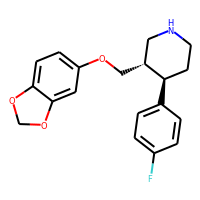
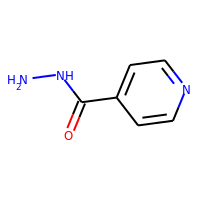

In [12]:
# Check if first_approval field is not empty
molecules[~molecules.first_approval.isna()]

**`CHEMBL64`, Isoniazid**

- [ChEMBL compound report card](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL64/)
- [Drugbank](https://www.drugbank.ca/drugs/DB00951)
  > **Description**: Antibacterial agent used primarily as a tuberculostatic. It remains the treatment of choice for tuberculosis. </br>
  > **Mechanism of action**: Isoniazid is a prodrug and must be activated by bacterial catalase. Specficially, activation is associated with reduction of the mycobacterial ferric **KatG catalase-peroxidase** by hydrazine and reaction with oxygen to form an oxyferrous enzyme complex. Once activated, isoniazid inhibits the synthesis of mycoloic acids, an essential component of the bacterial cell wall. At therapeutic levels isoniazid is bacteriocidal against actively growing intracellular and extracellular *Mycobacterium tuberculosis* organisms. Specifically isoniazid inhibits **InhA, the enoyl reductase** from *Mycobacterium tuberculosis*, by forming a covalent adduct with the NAD cofactor. It is the INH-NAD adduct that acts as a slow, tight-binding competitive inhibitor of InhA. </br>
  > **Target**: Catalase-peroxidase (UniProt ID [P9WIE5](https://www.uniprot.org/uniprot/P9WIE5))
  
- Off-targets? Kinases?
  - Cytochrome P450 2E1 and Arylamine N-acetyltranserases are associated with isoniazid side effects ([DrugBank's "Pharmacogenomic Effects/ADRs"](https://www.drugbank.ca/drugs/DB00951))
  - [SwissTargetPredictions](http://swisstargetprediction.ch/result.php?job=1698711713&organism=Homo_sapiens) (ligand-based target prediction) predicts a few kinases in the top 15 off-targets 
  - [ProBis](http://probis.cmm.ki.si/browse.php?job_id=2cca.A) (structure-based target prediction for [2CCA](https://www.rcsb.org/structure/2cca)) predicts mainly peroxidases (no kinases)

**`CHEMBL490`, Paroxetine**

- [ChEMBL compound report card](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL490/)
- [DrugBank](https://www.drugbank.ca/drugs/DB00715)
  > **Description**: Paroxetine is a selective serotonin reuptake inhibitor (SSRI) drug commonly known as Paxil. It has a variety of uses, including the treatment of anxiety disorders, major depression, posttraumatic stress disorder, and symptoms of menopause, among others. </br>
  > **Mode of action**: Paroxetine enhances serotonergic activity via the inhibition presynaptic reuptake of serotonin by the **serotonin (SERT) receptor**. This inhibition raises the level of serotonin in the synaptic cleft, relieving various symptoms. </br>
  > **Target**: Sodium-dependent serotonin transporter (UniProt ID [P31645](https://www.uniprot.org/uniprot/P31645))
- Off-targets? Kinases? 
  - Cytochrome P450 enzymes ([Sanchez et al. 2014](https://insights.ovid.com/article/00004850-201407000-00001)) and G protein-coupled receptor kinase 2 (GRK2 (AGC kinase group)) ([Thal et al. 2012](https://pubs.acs.org/doi/10.1021/cb3003013))
  - [SwissTargetPredictions](http://www.swisstargetprediction.ch/result.php?job=1696651044&organism=Homo_sapiens) (ligand-based target prediction) predicts many membrane receptors and channels - and from rank 15 on a variety of kinases
  - [ProBis](http://probis.cmm.ki.si/?what=job&job_id=25062009328288) (structure-based target prediction for [5I6X](https://www.rcsb.org/structure/5I6X)) predicts TBA (waiting for results)

#### ATC classified molecules?

In [13]:
# Check if atc classified field is not empty
molecules[molecules.atc_classifications.str.len() != 0].drop('ROMol', axis=1)

,molecule_chembl_id,first_approval,atc_classifications,indication_class,pref_name,smiles,inchi
83,CHEMBL490,1992.0,[N06AB05],Antidepressant,PAROXETINE,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,InChI=1S/C19H20FNO3/c20-15-3-1-13(2-4-15)17-7-...
260,CHEMBL64,1952.0,"[J04AC51, J04AC01]",Antibacterial (tuberculostatic),ISONIAZID,NNC(=O)c1ccncc1,InChI=1S/C6H7N3O/c7-9-6(10)5-1-3-8-4-2-5/h1-4H...


Same as retrieved via the approved molecules query.

### 2.4. Get molecules with human targets in ChEMBL

- Get activities (by molecule ChEMBL IDs)
- Remove activities for non-human target origanisms

#### Get activities (by molecule ChEMBL IDs)

In [14]:
def get_activities(molecule_ids):
    
    activities = activity_client.filter(
        molecule_chembl_id__in=molecule_ids,
        type='IC50', 
        relation='=', 
        assay_type='B'
    ).only(
        'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
        'molecule_chembl_id', 'type', 'standard_units', 'relation', 'standard_value', \
        'target_chembl_id', 'target_organism', 'target_pref_name'
    )
    
    activities_df = pd.DataFrame.from_records(list(activities))
    activities_df = activities_df.astype({'standard_value': 'float'})
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {activities_df.shape[0]}')
    
    return activities_df

In [15]:
activities = get_activities(list(molecules.molecule_chembl_id))

Number of queries: 299
Number of query results: 372


In [16]:
activities[activities.molecule_chembl_id == 'CHEMBL64']

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,type,units,value
299,16843814,CHEMBL3877133,Irreversible inhibition of MPO (unknown origin),B,CHEMBL64,=,nM,5000.0,CHEMBL2439,Homo sapiens,Myeloperoxidase,IC50,uM,5.0
300,16843827,CHEMBL3877132,Inhibition of human MPO,B,CHEMBL64,=,nM,4700.0,CHEMBL2439,Homo sapiens,Myeloperoxidase,IC50,uM,4.7


In [17]:
activities.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name', 'type',
       'units', 'value'],
      dtype='object')

In [18]:
filtering = add_filtering_step(filtering, activities, 'ChEMBL bioactivity entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,138,141,242,372


**Important**: Check if all standard units are really nM.

In [19]:
activities.groupby(
    ['standard_units']
).size()

standard_units
nM    372
dtype: int64

In [20]:
# Just to be sure, drop all entries with standard unit other than nM 
# Note: One could also perform a unit conversion here
activities.drop(
    index=activities[activities.standard_units != 'nM'].index,
    inplace=True
)

In [21]:
filtering = add_filtering_step(filtering, activities, 'Remove non-nM activities')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,138,141,242,372
1,Remove non-nM activities,138,141,242,372


#### Remove activities for non-human target organisms

In [22]:
activities.groupby('target_organism').size()

target_organism
Agaricus bisporus                   1
Bos taurus                          3
Escherichia coli K-12               1
Homo sapiens                      328
Human immunodeficiency virus 1      1
Mus musculus                        5
Ovis aries                          2
Photinus pyralis                    3
Photuris pennsylvanica              3
Rattus norvegicus                   4
Staphylococcus aureus               1
dtype: int64

In [23]:
activities = activities[activities.target_organism == 'Homo sapiens'].copy()
activities.drop('target_organism', axis=1, inplace=True)

In [24]:
filtering = add_filtering_step(filtering, activities, 'Only human entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,138,141,242,372
1,Remove non-nM activities,138,141,242,372
2,Only human entries,125,124,211,328


### 2.5. Check molecule/target/assay/bioactivity distributions

#### How many targets are reported per molecule?

Text(0.5, 0, 'Number of targets per molecule')

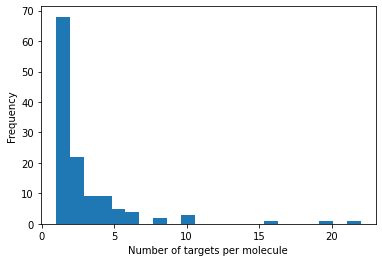

In [25]:
n_targets_per_molecule = activities.groupby(
    ['molecule_chembl_id']
)['target_chembl_id'].size()

ax = n_targets_per_molecule.plot(kind='hist', bins=n_targets_per_molecule.max())
ax.set_xlabel('Number of targets per molecule')

#### How many different assays were used to measure molecule-target activities?

Text(0.5, 0, 'Number of assays per molecule-target pair')

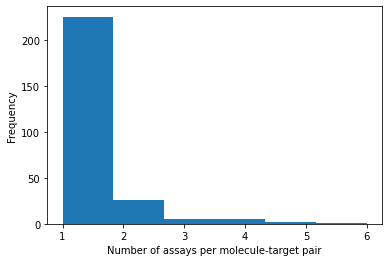

In [26]:
n_assays_per_molecule_target = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['assay_chembl_id'].size()

ax = n_assays_per_molecule_target.plot(kind='hist', bins=n_assays_per_molecule_target.max())
ax.set_xlabel('Number of assays per molecule-target pair')

#### Look at all activities measured per molecule-target-assay combination

Get all activities for each molecule-target-assay combination.

In [27]:
activities_per_molecule_target_assay = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description']
)['standard_value'].apply(list).reset_index()

Show examples.

In [28]:
activities_per_molecule_target_assay.head()

,molecule_chembl_id,target_chembl_id,target_pref_name,assay_chembl_id,assay_description,standard_value
0,CHEMBL1080394,CHEMBL2971,Tyrosine-protein kinase JAK2,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,[467.0]
1,CHEMBL1082236,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,[27.0]
2,CHEMBL1082821,CHEMBL2896,cGMP-dependent protein kinase 2,CHEMBL1120084,Inhibition of PRKG2,[24.0]
3,CHEMBL1082821,CHEMBL2973,Rho-associated protein kinase 2,CHEMBL1120081,Inhibition of ROCK2 by luciferase based ATP de...,[4.0]
4,CHEMBL1082821,CHEMBL3032,Protein kinase N2,CHEMBL1120085,Inhibition of PRKCL2,[14.0]


Get all activities for each molecule-target combination.

In [29]:
activities_per_molecule_target = activities_per_molecule_target_assay.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['standard_value'].apply(list).reset_index()

Get molecule-target pairs that have multiple activities from either multiple assays or a single assay.

In [30]:
activities_per_molecule_target[
    (activities_per_molecule_target.standard_value.apply(len) > 1) | (activities_per_molecule_target.standard_value.apply(len)[0] > 1)
].reset_index()

,index,molecule_chembl_id,target_chembl_id,standard_value
0,25,CHEMBL1287920,CHEMBL4630,"[[4.0], [7.0]]"
1,50,CHEMBL1652697,CHEMBL3629,"[[13.0, 6.0, 10.0], [7400.0]]"
2,53,CHEMBL1652706,CHEMBL3629,"[[4.0, 7.0], [2325.0]]"
3,57,CHEMBL2030386,CHEMBL2147,"[[13.0], [5.0]]"
4,62,CHEMBL2030386,CHEMBL5443,"[[5.5], [1805.0]]"
5,70,CHEMBL2170597,CHEMBL4722,"[[10.0], [8.9], [10.0], [10.0], [10.0]]"
6,73,CHEMBL2203552,CHEMBL2543,"[[348.0], [8.0]]"
7,88,CHEMBL2208034,CHEMBL2971,"[[695.0], [386.4], [2.2]]"
8,91,CHEMBL225519,CHEMBL2208,"[[470.0], [171.0]]"
9,96,CHEMBL225519,CHEMBL308,"[[250.0], [170.0]]"


### 2.6. Get active molecules (among the exact matches)

- Get highest activity (lowest IC50) per molecule-target pair
- Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

#### Get highest activity (lowest IC50) per molecule-target pair

Get lowest IC50 value per molecule-target pair by (i) sorting the DataFrame by molecule ChEMBL ID, target ChEMBL ID and activity value (ascending), (ii) group activites by molecule-target pairs, and (iii) take the first activity value (i.e. the minimum value because of step (ii)) per molecule-target pair (i.e. per group).

In [31]:
activities_min = activities.sort_values(
    ['molecule_chembl_id', 'target_chembl_id', 'standard_value']
).groupby(
    ['molecule_chembl_id', 'target_chembl_id']
).first().reset_index()

In [32]:
filtering = add_filtering_step(filtering, activities_min, 'Get minimum IC50 per molecule-target pair')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,138,141,242,372
1,Remove non-nM activities,138,141,242,372
2,Only human entries,125,124,211,328
3,Get minimum IC50 per molecule-target pair,125,124,172,264


#### Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

In [33]:
activities_active = activities_min[activities_min.standard_value <= ACTIVITY_THRESHOLD]
activities_active.head()

,molecule_chembl_id,target_chembl_id,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,standard_value,target_pref_name,type,units,value
0,CHEMBL1080394,CHEMBL2971,3227667,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,B,=,nM,467.0,Tyrosine-protein kinase JAK2,IC50,nM,467.0
1,CHEMBL1082236,CHEMBL262,3186376,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,B,=,nM,27.0,Glycogen synthase kinase-3 beta,IC50,uM,0.027
2,CHEMBL1082821,CHEMBL2896,3308846,CHEMBL1120084,Inhibition of PRKG2,B,=,nM,24.0,cGMP-dependent protein kinase 2,IC50,nM,24.0
3,CHEMBL1082821,CHEMBL2973,3308843,CHEMBL1120081,Inhibition of ROCK2 by luciferase based ATP de...,B,=,nM,4.0,Rho-associated protein kinase 2,IC50,nM,4.0
4,CHEMBL1082821,CHEMBL3032,3308847,CHEMBL1120085,Inhibition of PRKCL2,B,=,nM,14.0,Protein kinase N2,IC50,nM,14.0


In [34]:
filtering = add_filtering_step(filtering, activities_active, 'Only "active" molecule-target pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,138,141,242,372
1,Remove non-nM activities,138,141,242,372
2,Only human entries,125,124,211,328
3,Get minimum IC50 per molecule-target pair,125,124,172,264
4,"Only ""active"" molecule-target pairs",72,72,96,142


Text(0.5, 0, 'IC50 values for active molecule-target pairs')

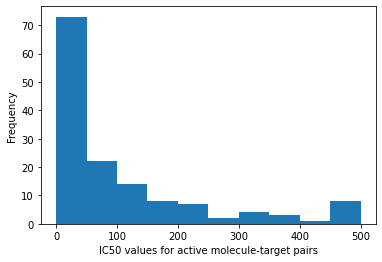

In [35]:
ax = activities_active.standard_value.plot(kind='hist')
ax.set_xlabel('IC50 values for active molecule-target pairs')

### 2.7. Get target metadata (PTC) for active molecules

- Get ChEMBL target details: Protein target classification (PTC)
- Show enzyme group distribution for unique target ChEMBL IDs
- Combine molecule, bioactivity, and target information

#### Get ChEMBL target details: Protein target classification (PTC)

In order to access the protein target classification, we follow the instructions given here: https://github.com/chembl/chembl_webservices_2/issues/95

In [36]:
target_chembl_ids = list(activities_active.target_chembl_id.unique())
print(f'Number of unique targets (target ChEMBL IDs): {len(target_chembl_ids)}')

Number of unique targets (target ChEMBL IDs): 72


Get PTC for target ChEMBL IDs.

In [37]:
protein_target_classifications = get_protein_target_classifications(target_chembl_ids)
print(f'Number of PTCs (multiple PTCs per target possible): {protein_target_classifications.shape[0]}')

Number of PTCs (multiple PTCs per target possible): 83


In [38]:
protein_target_classifications.head()

,target_chembl_id,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,component_id,protein_classification_id
0,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,152,1302,152
1,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakB family,None,None,None,153,1302,153
2,CHEMBL262,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase GSK family,None,None,None,239,3114,239
3,CHEMBL2896,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase PKG family,None,None,None,207,1226,207
4,CHEMBL2973,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase DMPK family,AGC protein kinase ROCK subfamily,None,None,315,1304,315


Show targets with multiple PTCs.

In [39]:
n_ptc_per_target = protein_target_classifications.groupby('target_chembl_id').size()
protein_target_classifications[protein_target_classifications.target_chembl_id.isin(n_ptc_per_target[n_ptc_per_target > 1].index)]

,target_chembl_id,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,component_id,protein_classification_id
0,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,152,1302,152
1,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakB family,None,None,None,153,1302,153
10,CHEMBL1907601,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,None,None,None,None,148,17,148
11,CHEMBL1907601,Other cytosolic protein,None,None,None,None,None,None,None,8,34,8
13,CHEMBL2095191,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129
14,CHEMBL2095191,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,1946,252
15,CHEMBL2095191,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,2389,252
20,CHEMBL3038477,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129
21,CHEMBL3038477,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,1946,252
22,CHEMBL3883328,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129


Select per target the PTC that has the least `None` values (if the same number of `None`, select first entry).

In [40]:
group_representatives = []

for name, group in protein_target_classifications.groupby('target_chembl_id', sort=False):
    
    if len(group) == 1:
        group_representatives.append(group)
    else:
        ix_least_none = group['l1 l2 l3 l4 l5 l6 l7 l8'.split()].isna().sum(axis=1).idxmin()
        group_representatives.append(group.loc[[ix_least_none]])
        
protein_target_classifications = pd.concat(group_representatives)
print(f'Number of PTCs (after deduplicating PTCs per target): {protein_target_classifications.shape[0]}')

Number of PTCs (after deduplicating PTCs per target): 72


#### Show enzyme group distribution for unique target ChEMBL IDs

In [41]:
protein_target_classifications.groupby(by='l2').size()

l2
Cytochrome P450                         1
Electrochemical transporter             2
Family A G protein-coupled receptor     4
Kinase                                 62
Oxidoreductase                          1
Voltage-gated ion channel               1
dtype: int64

#### Combine molecule, bioactivity, and target information

Merge bioactivities and PTC information on target ChEMBL IDs.

In [42]:
activities_active = pd.merge(
    activities_active, protein_target_classifications, on='target_chembl_id', how='left'
).sort_values(
    by=['molecule_chembl_id', 'standard_value']
)[['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'assay_chembl_id', 'assay_description', 'standard_value']]

activities_active.fillna('Unknown', inplace=True)

print(activities_active.shape)
activities_active.head()

(142, 12)


,molecule_chembl_id,target_chembl_id,target_pref_name,l1,l2,l3,l4,l5,l6,assay_chembl_id,assay_description,standard_value
0,CHEMBL1080394,CHEMBL2971,Tyrosine-protein kinase JAK2,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,Unknown,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,467.0
1,CHEMBL1082236,CHEMBL262,Glycogen synthase kinase-3 beta,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase GSK family,Unknown,CHEMBL1113275,Inhibition of human recombinant GSK3-beta usin...,27.0
3,CHEMBL1082821,CHEMBL2973,Rho-associated protein kinase 2,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase DMPK family,AGC protein kinase ROCK subfamily,CHEMBL1120081,Inhibition of ROCK2 by luciferase based ATP de...,4.0
4,CHEMBL1082821,CHEMBL3032,Protein kinase N2,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase PKN family,Unknown,CHEMBL1120085,Inhibition of PRKCL2,14.0
2,CHEMBL1082821,CHEMBL2896,cGMP-dependent protein kinase 2,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase PKG family,Unknown,CHEMBL1120084,Inhibition of PRKG2,24.0


### 2.8. Results

- Number of targets per molecule
- Targets per molecule
- Molecules without kinase target(s)
- Molecules with kinase target(s)
- Molecules with kinase target(s) with activity of <= 5 nM

`activities_active` contains information for each ChEMBL molecule-target combination.

#### Number of targets per molecule

Text(0.5, 0, 'Number of targets per molecule')

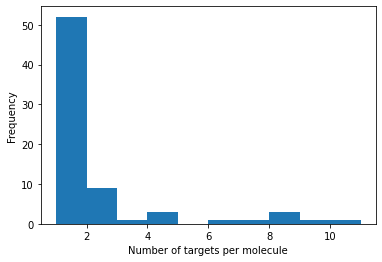

In [43]:
ax = activities_active.groupby(['molecule_chembl_id'])['target_chembl_id'].size().plot(kind='hist')
ax.set_xlabel('Number of targets per molecule')

#### Targets per molecule

In [44]:
pd.set_option("display.max_rows", 100)
pd.set_option('max_colwidth', 200)

In [45]:
molecules_with_targets = pd.DataFrame(
    [
        activities_active.groupby(['molecule_chembl_id'])['l2'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()

print(f'Number of molecules with human targets that have activity <= {ACTIVITY_THRESHOLD}: {molecules_with_targets.shape[0]}')

Number of molecules with human targets that have activity <= 500: 72


In [46]:
# Add molecule name
molecules_with_targets = pd.merge(
    molecules_with_targets, molecules[['molecule_chembl_id', 'pref_name']], on='molecule_chembl_id', how='left'
)

In [47]:
molecules_with_targets

,molecule_chembl_id,l2,target_pref_name,standard_value,pref_name
0,CHEMBL1080394,[Kinase],[Tyrosine-protein kinase JAK2],[467.0],None
1,CHEMBL1082236,[Kinase],[Glycogen synthase kinase-3 beta],[27.0],None
2,CHEMBL1082821,"[Kinase, Kinase, Kinase, Unknown]","[Rho-associated protein kinase 2, Protein kinase N2, cGMP-dependent protein kinase 2, Cell division control protein 42 homolog]","[4.0, 14.0, 24.0, 54.0]",None
3,CHEMBL1086638,[Kinase],[Glycogen synthase kinase-3 beta],[76.0],None
4,CHEMBL1086640,[Kinase],[Glycogen synthase kinase-3 beta],[195.0],None
5,CHEMBL1231626,[Kinase],[Serine/threonine-protein kinase Chk1],[3.0],None
6,CHEMBL1269663,[Kinase],[Vascular endothelial growth factor receptor 2],[107.2],None
7,CHEMBL1287863,[Kinase],[Serine/threonine-protein kinase Chk1],[2.0],None
8,CHEMBL1287920,[Kinase],[Serine/threonine-protein kinase Chk1],[4.0],None
9,CHEMBL1288009,[Kinase],[Serine/threonine-protein kinase Chk1],[3.0],None


#### Molecules without kinase target(s)

In [48]:
molecules_with_targets[~molecules_with_targets.l2.apply(lambda x: 'Kinase' in x)]

,molecule_chembl_id,l2,target_pref_name,standard_value,pref_name
15,CHEMBL1645408,[Cytochrome P450],[Cytochrome P450 11B2],[65.0],None
16,CHEMBL1645409,[Cytochrome P450],[Cytochrome P450 11B2],[104.0],None
60,CHEMBL4095993,[Voltage-gated ion channel],[Transient receptor potential cation channel subfamily A member 1],[42.0],None
64,CHEMBL490,"[Electrochemical transporter, Oxidoreductase, Electrochemical transporter, Family A G protein-coupled receptor, Family A G protein-coupled receptor, Family A G protein-coupled receptor, Family A G...","[Serotonin transporter, Myeloperoxidase, Norepinephrine transporter, Muscarinic acetylcholine receptor M5, Muscarinic acetylcholine receptor M1, Muscarinic acetylcholine receptor M3, Muscarinic ac...","[0.08, 20.0, 86.0, 123.0, 145.0, 179.0, 244.0]",PAROXETINE


#### Molecules with kinase target(s)

Keep only molecule-target pairs where target=kinase.

In [49]:
activities_active_kinases = activities_active[
    activities_active.l2 == 'Kinase'
]

In [50]:
filtering = add_filtering_step(filtering, activities_active_kinases, 'Only molecule-kinase pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,138,141,242,372
1,Remove non-nM activities,138,141,242,372
2,Only human entries,125,124,211,328
3,Get minimum IC50 per molecule-target pair,125,124,172,264
4,"Only ""active"" molecule-target pairs",72,72,96,142
5,Only molecule-kinase pairs,68,62,86,131


Across all molecule-target pairs count kinase groups.

In [51]:
activities_active_kinases.l4.apply(lambda x: x.split()[0]).value_counts()

TKL        32
TK         24
CMGC       22
Other      21
CAMK       19
AGC         6
Unknown     3
CK1         3
STE         1
Name: l4, dtype: int64

Summarize target information per molecule (`molecules_with_kinase_targets`).

In [52]:
molecules_with_kinase_targets = pd.DataFrame(
    [
        activities_active_kinases.groupby(['molecule_chembl_id'])['l4'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()
print(f'Number of molecules with kinase target(s): {molecules_with_kinase_targets.shape[0]}')

Number of molecules with kinase target(s): 68


Show molecules with kinase targets (sorted by the molecules' minimum activity value):

In [53]:
molecules_with_kinase_targets = molecules_with_kinase_targets.loc[molecules_with_kinase_targets.standard_value.apply(min).sort_values().index]
molecules_with_kinase_targets

,l4,target_pref_name,standard_value
molecule_chembl_id,,,
CHEMBL526479,"[TKL protein kinase group, CMGC protein kinase group]","[Serine/threonine-protein kinase B-raf, Mitogen-activated protein kinase; ERK1/ERK2]","[0.03, 9.0]"
CHEMBL1288278,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[1.0]
CHEMBL3403541,[TK protein kinase group],[Tyrosine-protein kinase JAK2],[1.0]
CHEMBL4080944,[CMGC protein kinase group],[MAP kinase ERK2],[1.2]
CHEMBL2385579,"[TKL protein kinase group, TK protein kinase group, TKL protein kinase group, TKL protein kinase group, Unknown, TKL protein kinase group, TKL protein kinase group, TKL protein kinase group]","[TGF-beta receptor type II, Vascular endothelial growth factor receptor 2, Bone morphogenetic protein receptor type-1A, Bone morphogenetic protein receptor type-2, AMP-activated protein kinase, be...","[1.37, 1.68, 10.4, 15.9, 39.9, 42.1, 53.4, 60.9]"
CHEMBL2203552,"[CMGC protein kinase group, CK1 protein kinase group, CK1 protein kinase group, CK1 protein kinase group]","[Glycogen synthase kinase-3 beta, Casein kinase I gamma 2, Casein kinase I alpha, Casein kinase I delta]","[1.491, 8.0, 9.0, 68.0]"
CHEMBL1615027,[TK protein kinase group],[Tyrosine-protein kinase JAK2],[1.8]
CHEMBL1287863,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[2.0]
CHEMBL2208034,"[TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, AGC protein kinase group, TK protein kinase g...","[Tyrosine-protein kinase JAK2, Platelet-derived growth factor receptor beta, Tyrosine-protein kinase JAK1, Tyrosine-protein kinase receptor FLT3, Tyrosine-protein kinase JAK3, Stem cell growth fac...","[2.2, 125.4, 134.3, 139.7, 214.2, 225.8, 313.8, 348.3, 370.0, 375.4, 483.6]"


In [54]:
# Add SMILES to molecule-kinase dataset
molecules_with_kinase_targets = pd.merge(
    molecules_with_kinase_targets, molecules[['molecule_chembl_id', 'smiles']], on='molecule_chembl_id', how='left'
)

Molecule ChEMBL ID | minimum activity value


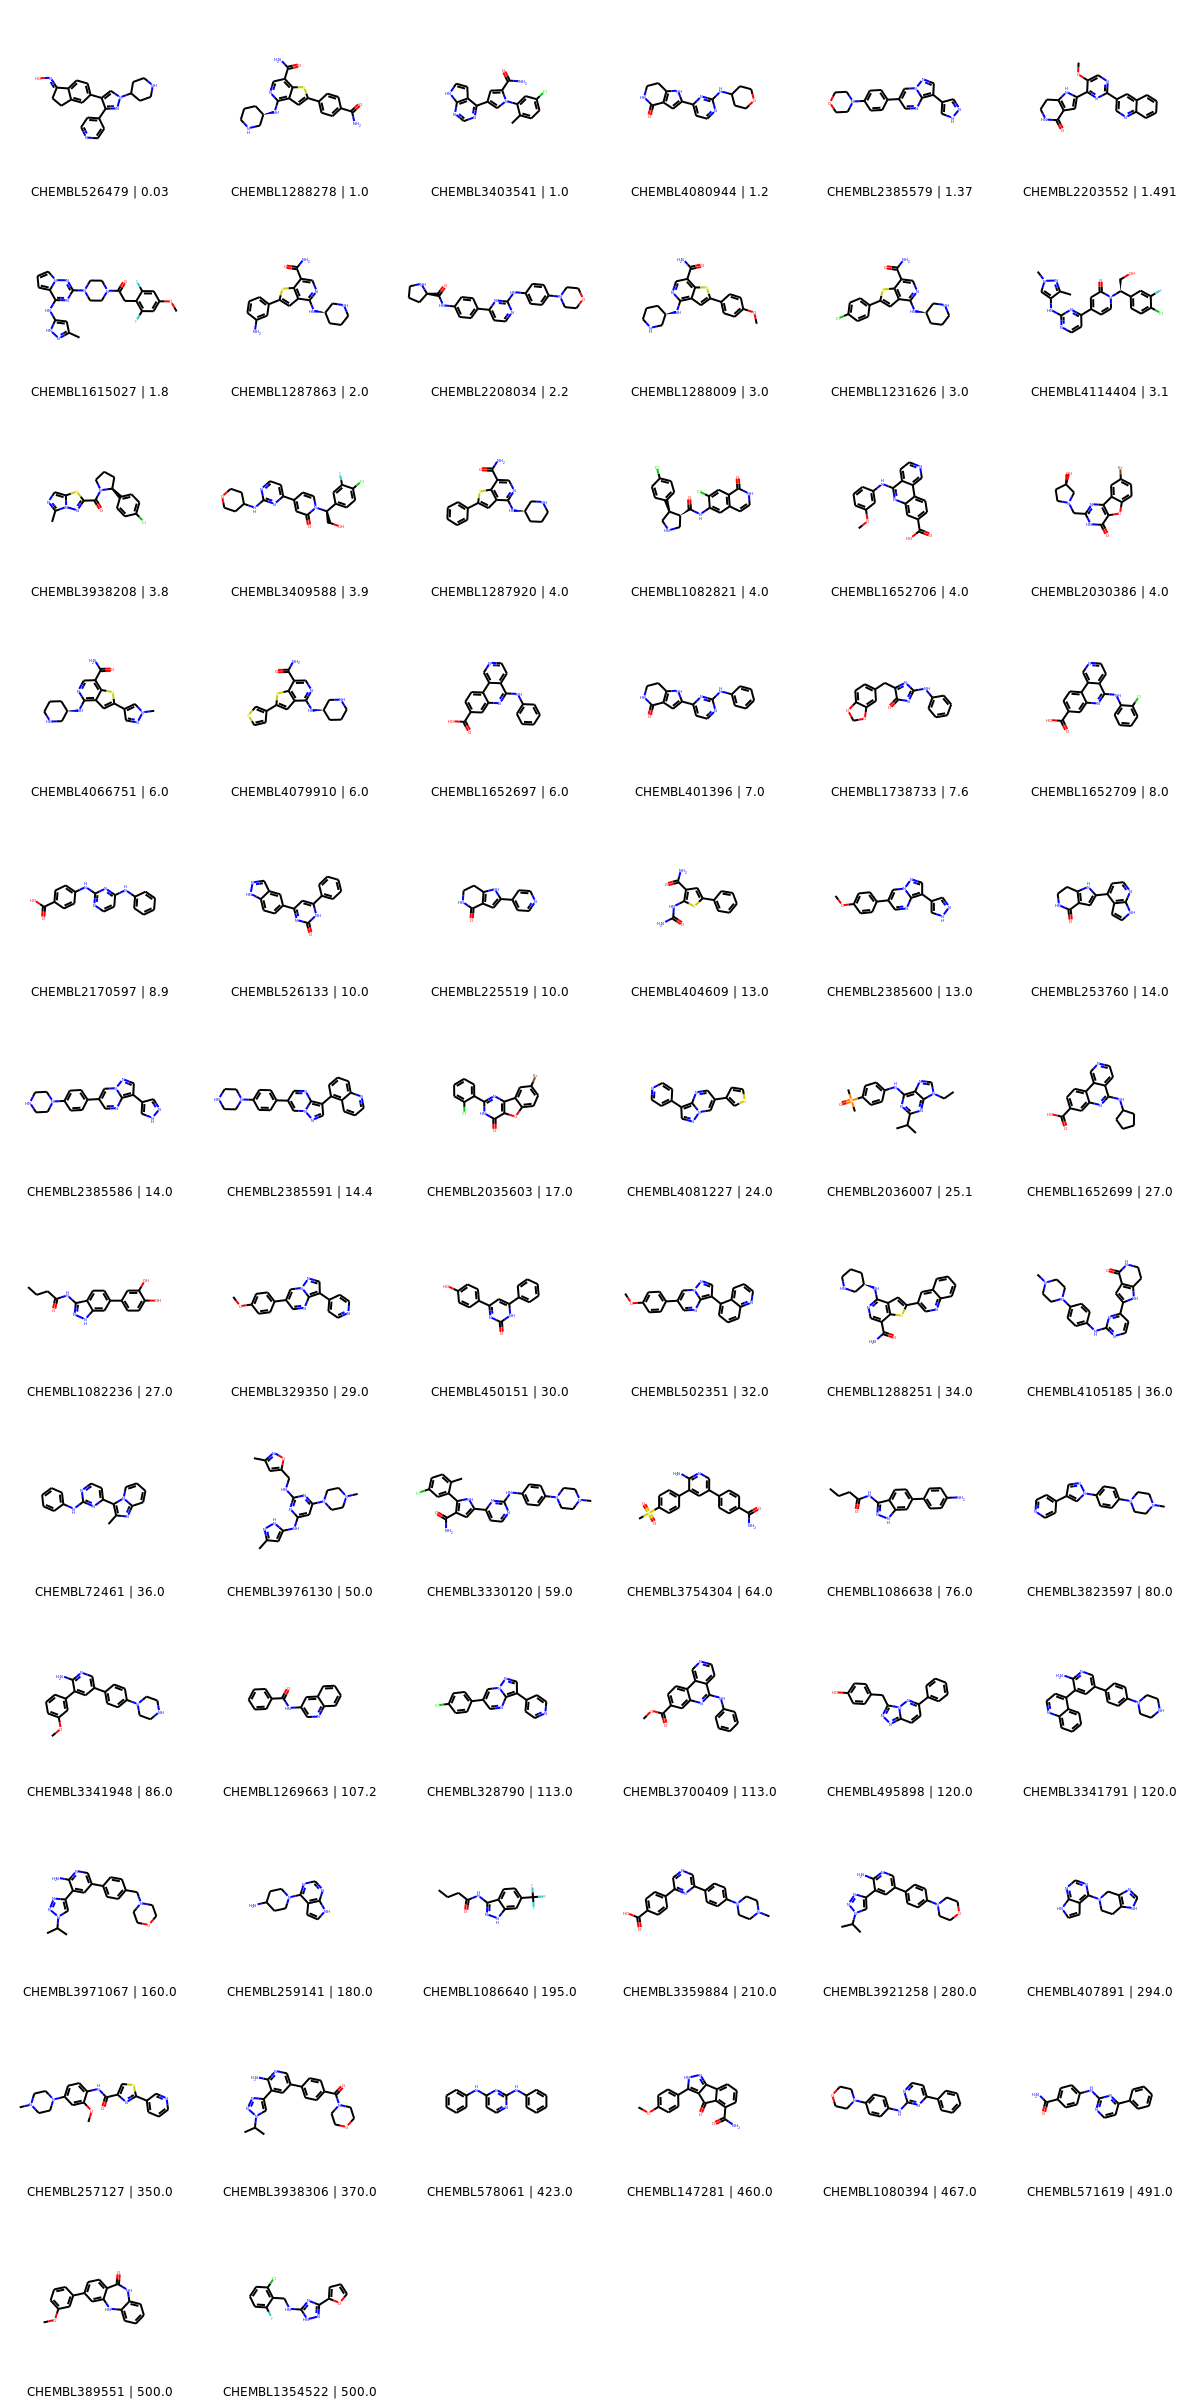

In [55]:
print(f'Molecule ChEMBL ID | minimum activity value')

image = Draw.MolsToGridImage(
    mols=molecules_with_kinase_targets.smiles.apply(lambda x: Chem.MolFromSmiles(x)).tolist(),
    legends=molecules_with_kinase_targets.apply(lambda x: f'{x.molecule_chembl_id} | {min(x.standard_value)}', axis=1).to_list(),
    molsPerRow=6,
    maxMols=100
)
image

In [56]:
image.save('figures/ligand_analysis_active_kinase_targets.pdf')

Show activity distribution for molecules with kinase target(s) - plot only minimum activity per molecule (in case there are multiple kinase activities measured).

Text(0.5, 0, 'Minimum activity value per molecule with kinase target(s)')

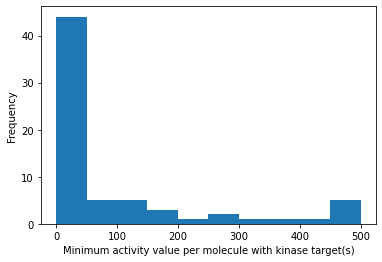

In [57]:
ax = molecules_with_kinase_targets.standard_value.apply(min).plot(kind='hist')
ax.set_xlabel('Minimum activity value per molecule with kinase target(s)')

#### Molecules with kinase target(s) with activity of <= 5 nM

In [58]:
activities_active_kinases_5nm = activities_active_kinases[
    activities_active_kinases.standard_value <= 5
]

In [59]:
print(f'Number of molecules with kinase target(s) and an activity of <= 5 nM: {activities_active_kinases_5nm.groupby("molecule_chembl_id").first().shape[0]}')

Number of molecules with kinase target(s) and an activity of <= 5 nM: 18


In [60]:
filtering = add_filtering_step(filtering, activities_active_kinases_5nm, 'Only molecule-kinase pairs with activity <= 5 nM')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,138,141,242,372
1,Remove non-nM activities,138,141,242,372
2,Only human entries,125,124,211,328
3,Get minimum IC50 per molecule-target pair,125,124,172,264
4,"Only ""active"" molecule-target pairs",72,72,96,142
5,Only molecule-kinase pairs,68,62,86,131
6,Only molecule-kinase pairs with activity <= 5 nM,18,13,17,21
